In [4]:
import requests
import time
from datetime import datetime
def get_market_by_slug(slug: str) -> dict:
    """Fetch market details directly by slug (no searching)"""
    response = requests.get(
        f"https://gamma-api.polymarket.com/markets",
        params={"slug": slug}
    )
    markets = response.json()
    return markets[0] if markets else None
def get_btc_15m_market(timestamp: int) -> dict:
    """Get BTC 15-min market for a specific timestamp"""
    slug = f"btc-updown-15m-{timestamp}"
    return get_market_by_slug(slug)
def get_next_market_timestamp(current_ts: int) -> int:
    """Calculate next 15-min market timestamp"""
    return current_ts + 900
# Example: Get current market
current_ts = 1766347200
market = get_btc_15m_market(current_ts)
if market:
    print(f"Question: {market['question']}")
    print(f"End Date: {market['endDate']}")
    print(f"Condition ID: {market['conditionId']}")
    print(f"Token IDs: {market['clobTokenIds']}")  # This is what WebSocket needs

    yes_token_id = market['clobTokenIds'][0]
    no_token_id = market['clobTokenIds'][1]

Question: Bitcoin Up or Down - December 21, 3:00PM-3:15PM ET
End Date: 2025-12-21T20:15:00Z
Condition ID: 0x1f0f05a76eae3da1e3102e6a54f286b09671e70cc14a2613d8f3e751f0b9b1af
Token IDs: ["75995766234967513411537406439498013485716402981988829067667204095598957586296", "97548473237954476983475202265865413448309341827982116332234829825664362327984"]


In [ ]:
import json
import threading
import requests
import pandas as pd
from websocket import WebSocketApp
from datetime import datetime
import time

# ============ CONFIGURATION (UPDATE THESE) ============
# TOKEN_ID = "77659131609082989710007605993140565011705938721134954735628818471535201171215"                           # From Gamma API
TOKEN_ID_UP = "75995766234967513411537406439498013485716402981988829067667204095598957586296"      # Up asset_id
TOKEN_ID_DOWN = "97548473237954476983475202265865413448309341827982116332234829825664362327984"    # Down asset_id
MARKET_SLUG = "btc-updown-15m-1766347200"                 # Current market slug
MARKET_END_UNIX = 1766347200 + 900                        # Slug timestamp + 900 seconds
USER_ADDRESS = "0x6031b6eed1c97e853c6e0f03ad3ce3529351f96d"

# ============ SHARED STATE ============
bids = []
asks = []
btc_price = None
books = {
    TOKEN_ID_UP: {"bids": [], "asks": []},
    TOKEN_ID_DOWN: {"bids": [], "asks": []},
}
books_lock = threading.Lock()  # optional but good

# ============ DATA STORAGE ============
orderbook_snapshots = []
user_trades = []
seen_hashes = set()

: 

In [8]:
# ============ WEBSOCKET: Live Orderbook ============
# def on_open(ws):
#     print("[WS] Connected")
#     ws.send(json.dumps({"assets_ids": [TOKEN_ID], "type": "market"}))

def on_open(ws):
    print("[WS] Connected")
    ws.send(json.dumps({"assets_ids": [TOKEN_ID_UP, TOKEN_ID_DOWN], "type": "market"}))

def on_message(ws, message):
    if message == "PONG":
        return
    data = json.loads(message)
    events = data if isinstance(data, list) else [data]

    for event in events:
        if event.get("event_type") != "book":
            continue

        asset_id = event.get("asset_id")
        if asset_id not in books:
            continue

        with books_lock:
            books[asset_id]["bids"] = event.get("bids", []) or []
            books[asset_id]["asks"] = event.get("asks", []) or []

ws = WebSocketApp(
    "wss://ws-subscriptions-clob.polymarket.com/ws/market",
    on_open=on_open,
    on_message=on_message
)
threading.Thread(target=ws.run_forever, daemon=True).start()
print("[WS] Orderbook thread started")

[WS] Orderbook thread started


In [10]:
# ============ BTC PRICE POLLER (CoinGecko) ============
def btc_poller():
    global btc_price
    while True:
        try:
            r = requests.get(
                "https://api.coingecko.com/api/v3/simple/price",
                params={"ids": "bitcoin", "vs_currencies": "usd"},
                timeout=5
            )
            btc_price = float(r.json()["bitcoin"]["usd"])
        except Exception as e:
            print(f"[BTC] Error: {e}")
        time.sleep(1)  # CoinGecko rate limit is stricter

threading.Thread(target=btc_poller, daemon=True).start()
print("[BTC] Price poller started")

[BTC] Price poller started


In [12]:
# ============ ORDERBOOK SAMPLER (10x per second) ============
def top_of_book_levels(levels, n=5):
    """
    levels: list of dicts like {"price": "...", "size": "..."}
    Returns: (best_price, best_size, depth_n)
    Assumes levels are sorted best-at-end (like your current code).
    If ordering is opposite, flip indices (see note below).
    """
    if not levels:
        return (None, None, None)

    best = levels[-1]
    best_price = float(best["price"])
    best_size = float(best["size"])
    depth_n = sum(float(x["size"]) for x in levels[-n:]) if len(levels) >= 1 else 0.0
    return (best_price, best_size, depth_n)
    
def sampler():
    while True:
        now_unix = int(time.time())

        if btc_price:
            with books_lock:
                up_bids = books[TOKEN_ID_UP]["bids"]
                up_asks = books[TOKEN_ID_UP]["asks"]
                down_bids = books[TOKEN_ID_DOWN]["bids"]
                down_asks = books[TOKEN_ID_DOWN]["asks"]

            # Require both sides to exist for both tokens (you can relax this)
            if up_bids and up_asks and down_bids and down_asks:
                up_best_bid, up_bid_size, up_bid_depth_5 = top_of_book_levels(up_bids, n=5)
                up_best_ask, up_ask_size, up_ask_depth_5 = top_of_book_levels(up_asks, n=5)

                down_best_bid, down_bid_size, down_bid_depth_5 = top_of_book_levels(down_bids, n=5)
                down_best_ask, down_ask_size, down_ask_depth_5 = top_of_book_levels(down_asks, n=5)

                orderbook_snapshots.append({
                    "timestamp_unix": now_unix,
                    "market_slug": MARKET_SLUG,

                    # Up token (what you pay to buy Up immediately)
                    "up_best_ask": up_best_ask,
                    "up_ask_size": up_ask_size,
                    "up_ask_depth_5": up_ask_depth_5,

                    # Down token (what you pay to buy Down immediately)
                    "down_best_ask": down_best_ask,
                    "down_ask_size": down_ask_size,
                    "down_ask_depth_5": down_ask_depth_5,

                    # Optional: keep bids too, useful for spread / execution modeling
                    "up_best_bid": up_best_bid,
                    "down_best_bid": down_best_bid,

                    # Optional spreads
                    "up_spread": up_best_ask - up_best_bid,
                    "down_spread": down_best_ask - down_best_bid,

                    "seconds_to_expiry": max(0, MARKET_END_UNIX - now_unix),
                    "btc_price": btc_price,
                })

        time.sleep(0.1)

threading.Thread(target=sampler, daemon=True).start()
print("[SAMPLER] Orderbook sampler started")

[BTC] Error: 'bitcoin'
[SAMPLER] Orderbook sampler started


In [14]:
# ============ TRADE POLLER ============
def trade_poller():
    while True:
        try:
            r = requests.get(
                "https://data-api.polymarket.com/trades",
                params={"user": USER_ADDRESS, "limit": 100},
                timeout=2
            )
            for trade in r.json():
                tx_hash = trade.get("transactionHash")
                slug = trade.get("slug", "")
                
                if "btc-updown-15m" not in slug:
                    continue
                    
                if tx_hash and tx_hash not in seen_hashes:
                    seen_hashes.add(tx_hash)
                    user_trades.append({
                        "timestamp_unix": trade.get("timestamp"),
                        "market_slug": slug,
                        "side": trade.get("side"),
                        "price": trade.get("price"),
                        "size": trade.get("size"),
                        "outcome": trade.get("outcome"),
                        "tx_hash": tx_hash
                    })
                    print(f"[TRADE] {trade.get('side')} {trade.get('size')} @ {trade.get('price')}")
        except Exception as e:
            print(f"[TRADE] Error: {e}")
        time.sleep(0.1)

threading.Thread(target=trade_poller, daemon=True).start()
print("[TRADE] Trade poller started")

[TRADE] Trade poller started


In [16]:
# Status check
print(f"BTC Price: ${btc_price:,.2f}" if btc_price else "BTC: waiting...")
print(f"Book levels: {len(bids)} bids, {len(asks)} asks")
print(f"Snapshots: {len(orderbook_snapshots)}")
print(f"Trades: {len(user_trades)}")

BTC Price: $88,476.00
Book levels: 0 bids, 0 asks
Snapshots: 141
Trades: 52


In [18]:
import pandas as pd

ob_df = pd.DataFrame(orderbook_snapshots)
trades_df = pd.DataFrame(user_trades)

print("=== TIMESTAMP RANGES ===")
print(f"Trades: {trades_df['timestamp_unix'].min()} to {trades_df['timestamp_unix'].max()}")
print(f"Orderbook: {ob_df['timestamp_unix'].min()} to {ob_df['timestamp_unix'].max()}")

=== TIMESTAMP RANGES ===
Trades: 1766346664 to 1766346966
Orderbook: 1766347238 to 1766347271


In [20]:
# Run this every minute or so
ob_start = pd.DataFrame(orderbook_snapshots)["timestamp_unix"].min()
new_trades = [t for t in user_trades if t["timestamp_unix"] >= ob_start]
print(f"Trades with matching orderbook data: {len(new_trades)}")

Trades with matching orderbook data: 0


In [22]:
# Run this every minute or so
ob_start = pd.DataFrame(orderbook_snapshots)["timestamp_unix"].min()
new_trades = [t for t in user_trades if t["timestamp_unix"] >= ob_start]
print(f"Trades with matching orderbook data: {len(new_trades)}")

[BTC] Error: 'bitcoin'
Trades with matching orderbook data: 8


In [24]:
# Run this every minute or so
ob_start = pd.DataFrame(orderbook_snapshots)["timestamp_unix"].min()
new_trades = [t for t in user_trades if t["timestamp_unix"] >= ob_start]
print(f"Trades with matching orderbook data: {len(new_trades)}")

Trades with matching orderbook data: 20


In [26]:
# Run this every minute or so
ob_start = pd.DataFrame(orderbook_snapshots)["timestamp_unix"].min()
new_trades = [t for t in user_trades if t["timestamp_unix"] >= ob_start]
print(f"Trades with matching orderbook data: {len(new_trades)}")

Trades with matching orderbook data: 31


In [28]:
# Run this every minute or so
ob_start = pd.DataFrame(orderbook_snapshots)["timestamp_unix"].min()
new_trades = [t for t in user_trades if t["timestamp_unix"] >= ob_start]
print(f"Trades with matching orderbook data: {len(new_trades)}")

Trades with matching orderbook data: 31


In [30]:
# Run this every minute or so
ob_start = pd.DataFrame(orderbook_snapshots)["timestamp_unix"].min()
new_trades = [t for t in user_trades if t["timestamp_unix"] >= ob_start]
print(f"Trades with matching orderbook data: {len(new_trades)}")

Trades with matching orderbook data: 31


In [32]:
# Run this every minute or so
ob_start = pd.DataFrame(orderbook_snapshots)["timestamp_unix"].min()
new_trades = [t for t in user_trades if t["timestamp_unix"] >= ob_start]
print(f"Trades with matching orderbook data: {len(new_trades)}")

Trades with matching orderbook data: 33


In [34]:
# Run this every minute or so
ob_start = pd.DataFrame(orderbook_snapshots)["timestamp_unix"].min()
new_trades = [t for t in user_trades if t["timestamp_unix"] >= ob_start]
print(f"Trades with matching orderbook data: {len(new_trades)}")

Trades with matching orderbook data: 40


In [44]:
import pandas as pd

ob_df = pd.DataFrame(orderbook_snapshots)
trades_df = pd.DataFrame(user_trades)

merged = pd.merge_asof(
    trades_df.sort_values("timestamp_unix"),
    ob_df.sort_values("timestamp_unix"),
    on="timestamp_unix",
    direction="backward",
    suffixes=("_trade", "_book")
)

print(f"Merged rows: {len(merged)}")
display(merged.tail(42))

Merged rows: 113


,timestamp_unix,market_slug_trade,side,price,size,outcome,tx_hash,market_slug_book,up_best_ask,up_ask_size,up_ask_depth_5,down_best_ask,down_ask_size,down_ask_depth_5,up_best_bid,down_best_bid,up_spread,down_spread,seconds_to_expiry,btc_price
71,1766347394,btc-updown-15m-1766347200,BUY,0.45,5.00,Up,0x059abfdfeb09bf3ef1a4b3df69ad4e77ae63390ad433...,btc-updown-15m-1766347200,0.35,55.24,751.46,0.66,40.00,1624.56,0.34,0.65,0.01,0.01,706.0,88458.0
72,1766347432,btc-updown-15m-1766347200,BUY,0.69,3.81,Down,0x5f02a79d0445ae87c3bf4e02a5d9f2cfc26819b480f2...,btc-updown-15m-1766347200,0.33,76.22,2506.98,0.69,50.00,2946.59,0.31,0.67,0.02,0.02,668.0,88462.0
73,1766347438,btc-updown-15m-1766347200,BUY,0.70,5.00,Down,0xdd6a8864f478b0f7685910044011a01d134151f3da0a...,btc-updown-15m-1766347200,0.25,305.20,1673.31,0.77,179.69,2015.70,0.23,0.75,0.02,0.02,662.0,88462.0
74,1766347440,btc-updown-15m-1766347200,BUY,0.70,20.00,Down,0x44b0985430a80f857acde6ffb79a764ae20561dbaf0a...,btc-updown-15m-1766347200,0.27,173.92,2518.88,0.75,75.00,2392.50,0.25,0.73,0.02,0.02,660.0,88462.0
75,1766347468,btc-updown-15m-1766347200,BUY,0.30,20.00,Up,0xb08bbb2b0be105049ce6e2085e2b6654ff37d9ec4745...,btc-updown-15m-1766347200,0.30,197.22,3705.98,0.72,159.30,1644.14,0.28,0.70,0.02,0.02,632.0,88462.0
76,1766347540,btc-updown-15m-1766347200,BUY,0.75,2.83,Down,0x86200163fd4e1f217c63f8cb9414dea4fdfa1188ca53...,btc-updown-15m-1766347200,0.19,16.13,654.27,0.82,165.00,1710.70,0.18,0.81,0.01,0.01,560.0,88444.0
77,1766347540,btc-updown-15m-1766347200,BUY,0.75,20.00,Down,0x125ede19c957a4acbc82f822e85a9d85ac617432898c...,btc-updown-15m-1766347200,0.19,16.13,654.27,0.82,165.00,1710.70,0.18,0.81,0.01,0.01,560.0,88444.0
78,1766347550,btc-updown-15m-1766347200,BUY,0.79,14.00,Down,0xf7d5b6702f0420e31ef6268c0f3e5d674b2a796b4926...,btc-updown-15m-1766347200,0.22,207.84,1999.26,0.79,157.92,1191.93,0.21,0.78,0.01,0.01,550.0,88427.0
79,1766347552,btc-updown-15m-1766347200,BUY,0.25,20.00,Up,0x8e9701a9e72a5412b9d23697c920c9ae48d47e8c8718...,btc-updown-15m-1766347200,0.22,162.47,2016.89,0.79,151.58,1160.31,0.21,0.78,0.01,0.01,548.0,88427.0
80,1766347552,btc-updown-15m-1766347200,BUY,0.25,20.00,Up,0xef62e9c32254cf08b7750772a81b34823fb8dfe89d88...,btc-updown-15m-1766347200,0.22,162.47,2016.89,0.79,151.58,1160.31,0.21,0.78,0.01,0.01,548.0,88427.0


In [48]:
import numpy as np

df = merged.sort_values("timestamp_unix").copy()

# Market state
df["sum_asks"]   = df["up_best_ask"] + df["down_best_ask"]
df["sum_bids"]   = df["up_best_bid"] + df["down_best_bid"]
df["ask_skew"]   = df["up_best_ask"] - df["down_best_ask"]   # + => Up more expensive than Down
df["bid_skew"]   = df["up_best_bid"] - df["down_best_bid"]

df["up_mid"]     = (df["up_best_bid"] + df["up_best_ask"]) / 2
df["down_mid"]   = (df["down_best_bid"] + df["down_best_ask"]) / 2

# Trade encoding
df["is_buy"]     = (df["side"] == "BUY")
df["q"]          = df["size"].astype(float) * np.where(df["is_buy"], 1.0, -1.0)

df["up_q"]       = np.where(df["outcome"] == "Up",   df["q"], 0.0)
df["down_q"]     = np.where(df["outcome"] == "Down", df["q"], 0.0)

# Inventory state (smoking gun for "hedge the other side")
df["pos_up"]     = df["up_q"].cumsum()
df["pos_down"]   = df["down_q"].cumsum()
df["net_pos"]    = df["pos_up"] - df["pos_down"]
df["gross_pos"]  = df["pos_up"] + df["pos_down"]
df["hedged_ratio"] = np.minimum(df["pos_up"], df["pos_down"]) / np.maximum(df["pos_up"], df["pos_down"]).replace(0, np.nan)

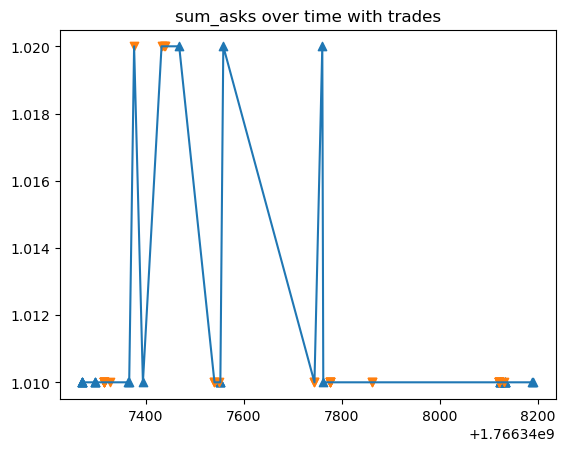

In [50]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["timestamp_unix"], df["sum_asks"])
plt.scatter(df.loc[df["outcome"]=="Up","timestamp_unix"], df.loc[df["outcome"]=="Up","sum_asks"], marker="^")
plt.scatter(df.loc[df["outcome"]=="Down","timestamp_unix"], df.loc[df["outcome"]=="Down","sum_asks"], marker="v")
plt.title("sum_asks over time with trades")
plt.show()

In [52]:
down_buy = df[(df["outcome"]=="Down") & (df["is_buy"])]
up_buy   = df[(df["outcome"]=="Up") & (df["is_buy"])]

print("Down-buy sum_asks mean:", down_buy["sum_asks"].mean())
print("Up-buy   sum_asks mean:", up_buy["sum_asks"].mean())
print("Pct Down-buys with sum_asks<1:", (down_buy["sum_asks"]<1).mean())
print("Pct Up-buys   with sum_asks<1:", (up_buy["sum_asks"]<1).mean())

[BTC] Error: 'bitcoin'
Down-buy sum_asks mean: 1.0112500000000002
Up-buy   sum_asks mean: 1.0110344827586208
Pct Down-buys with sum_asks<1: 0.0
Pct Up-buys   with sum_asks<1: 0.0


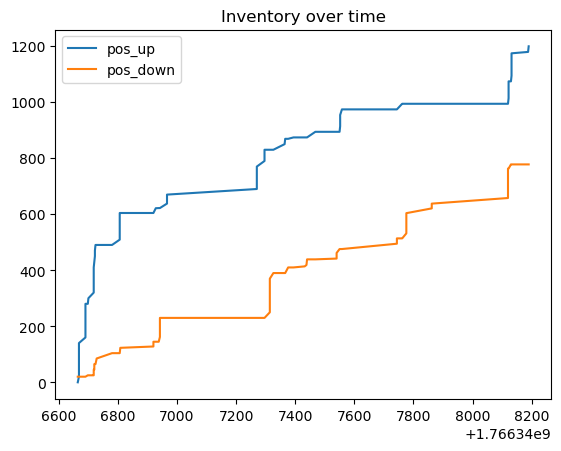

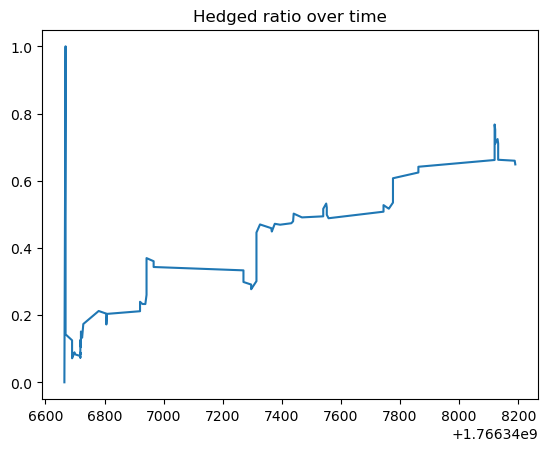

In [54]:
plt.figure()
plt.plot(df["timestamp_unix"], df["pos_up"], label="pos_up")
plt.plot(df["timestamp_unix"], df["pos_down"], label="pos_down")
plt.legend(); plt.title("Inventory over time"); plt.show()

plt.figure()
plt.plot(df["timestamp_unix"], df["hedged_ratio"])
plt.title("Hedged ratio over time"); plt.show()

In [56]:
df["btc_ret_5s"] = df["btc_price"].diff(5)  # rough if 1s sampling; adjust to your data
up = df[df["outcome"]=="Up"]
down = df[df["outcome"]=="Down"]
print(up["btc_ret_5s"].describe())
print(down["btc_ret_5s"].describe())

count    24.000000
mean     -5.083333
std      10.557983
min     -35.000000
25%      -3.500000
50%       0.000000
75%       0.000000
max       4.000000
Name: btc_ret_5s, dtype: float64
count    32.000000
mean     -8.375000
std      10.187754
min     -35.000000
25%     -16.000000
50%      -5.000000
75%       0.000000
max       4.000000
Name: btc_ret_5s, dtype: float64
